

# Assignment (BioNT Applied Machine Learning for Biological Data)

*Extend a machine learning workflow you learned in the Day 3 hands-on session (Complete Machine Learning Workflow) to compare the performance of two classification algorithms*

So in the Day 3 hands-on session, we completed a full machine learning workflow using a glioma grading dataset. This dataset included three clinical features and 20 gene mutation signatures. The target variable was glioma grade, encoded as 0 for Lower-Grade Glioma (LGG) and 1 for Glioblastoma Multiforme (GBM)

We used a logistic regression classifier to predict glioma grade based on these features. That makes sense as a starting point because the task is binary classification and logistic regression is both simple and interpretable

Now in this assignment, the goal is to reproduce those Day 3 results and then go further. We will bring in other classification algorithms to compare how they perform on the same task. We will interpret the results, look at different evaluation metrics, and try to understand which model does best and why




 # Problem Statement

Before moving on, I think it's important to actually understand what the problem is and what the dataset represents. That helps shape our approach.

We’re working with a glioma grading dataset, and the goal is to predict whether a patient has a high-grade or low-grade brain tumor based on clinical features and gene mutation signatures. Essentially, we want to classify patients into more serious or less serious categories. Why is this important? Well, first, it can help in tailoring personalized treatment plans based on predicted outcomes. Second, we can analyze which features contribute most to the classification, and potentially use that information to guide future research or clinical decisions

## Dataset

This dataset contains records from patients diagnosed with glioma. The data is based on the TCGA-LGG (Lower Grade Glioma) and TCGA-GBM (Glioblastoma Multiforme) projects

Each patient record is described by 20 molecular features (indicating the mutation status of specific genes) and 3 clinical features related to patient demographics

Link to the dataset: [Glioma Grading Dataset (UCI)](https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset)


## Loading necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

## Exploratory Data Analysis

*Why do we even need to do exploratory data analysis?*

Data is everything. If you put garbage in, you get garbage out. So before we jump into modeling, we need to understand what kind of data we're dealing with. This means inspecting the dataset to check for inconsistencies in naming conventions, missing values, unusual distributions, or weird data types. 

We also want to see if any features seem obviously correlated, if there’s class imbalance, and generally whether things look clean or sketchy. This step is critical because it gives us a broader picture of the problem. In some cases, EDA even helps us come up with new feature ideas that we wouldn't have thought of just by staring at the raw columns.

So here’s the general plan for EDA:

1. Understand the Data Structure and Summary  
   1. Load the dataset and inspect the shape, column names, and data types  
   2. Use descriptive statistics to get a sense of ranges, distributions, and outliers  

2. Analyze the Target Variable  
   1. Check the data type and make sure it's set up correctly for classification  
   2. See how balanced the classes are (0 vs. 1)  

3. Analyze the Features  
   1. Visualize the distributions of each feature to get a sense of spread, skew, and outliers  

4. Identify and Handle Missing Values  
   1. Look for any features with missing data  
   2. Decide whether to drop, impute, or otherwise handle those missing values depending on context


In [2]:
# Read the dataset to get the glioma dataframe
gliomas = pd.read_csv('TCGA_InfoWithGrade.csv')
gliomas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Grade             839 non-null    float64
 1   Gender            840 non-null    float64
 2   Age_at_diagnosis  839 non-null    float64
 3   Race              839 non-null    float64
 4   IDH1              839 non-null    float64
 5   TP53              839 non-null    float64
 6   ATRX              839 non-null    float64
 7   PTEN              839 non-null    float64
 8   EGFR              840 non-null    float64
 9   CIC               839 non-null    float64
 10  MUC16             839 non-null    float64
 11  PIK3CA            839 non-null    float64
 12  NF1               839 non-null    float64
 13  PIK3R1            840 non-null    float64
 14  FUBP1             839 non-null    float64
 15  RB1               839 non-null    float64
 16  NOTCH1            840 non-null    float64
 1

In [3]:
# Inspect the first few rows of the DataFrame
gliomas.head()

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,ATRX_xNA,IDH1_xNA
0,0.0,0.0,51.30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,38.72,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,35.17,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,0.0,1.0,32.78,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
4,0.0,0.0,31.51,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4]:
# Quick summary statistics of the DataFrame
gliomas.describe()

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,ATRX_xNA,IDH1_xNA
count,839.000000,840.000000,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000,840.000000,839.000000,...,840.000000,839.000000,839.000000,839.000000,839.000000,840.000000,839.000000,840.000000,630.000000,168.000000
mean,0.419547,0.417857,50.935411,0.107271,0.481526,0.414779,0.258641,0.168057,0.133333,0.132300,...,0.045238,0.034565,0.032181,0.032181,0.032181,0.027381,0.027414,0.026190,0.265079,0.488095
std,0.493779,0.493500,15.702339,0.369392,0.499957,0.492978,0.438149,0.374140,0.340137,0.339019,...,0.207950,0.182784,0.176586,0.176586,0.176586,0.163288,0.163383,0.159797,0.441726,0.501353
min,0.000000,0.000000,14.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,38.055000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,51.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,62.800000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,89.290000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Analysing the Target Variable

In [5]:
# Get the counts of each grade in the 'Grade' column
gliomas["Grade"].value_counts()

Grade
0.0    487
1.0    352
Name: count, dtype: int64

In [6]:
# Get the fractions of each grade in the 'Grade' column
gliomas["Grade"].value_counts(normalize=True)

Grade
0.0    0.580453
1.0    0.419547
Name: proportion, dtype: float64

### Analyze features

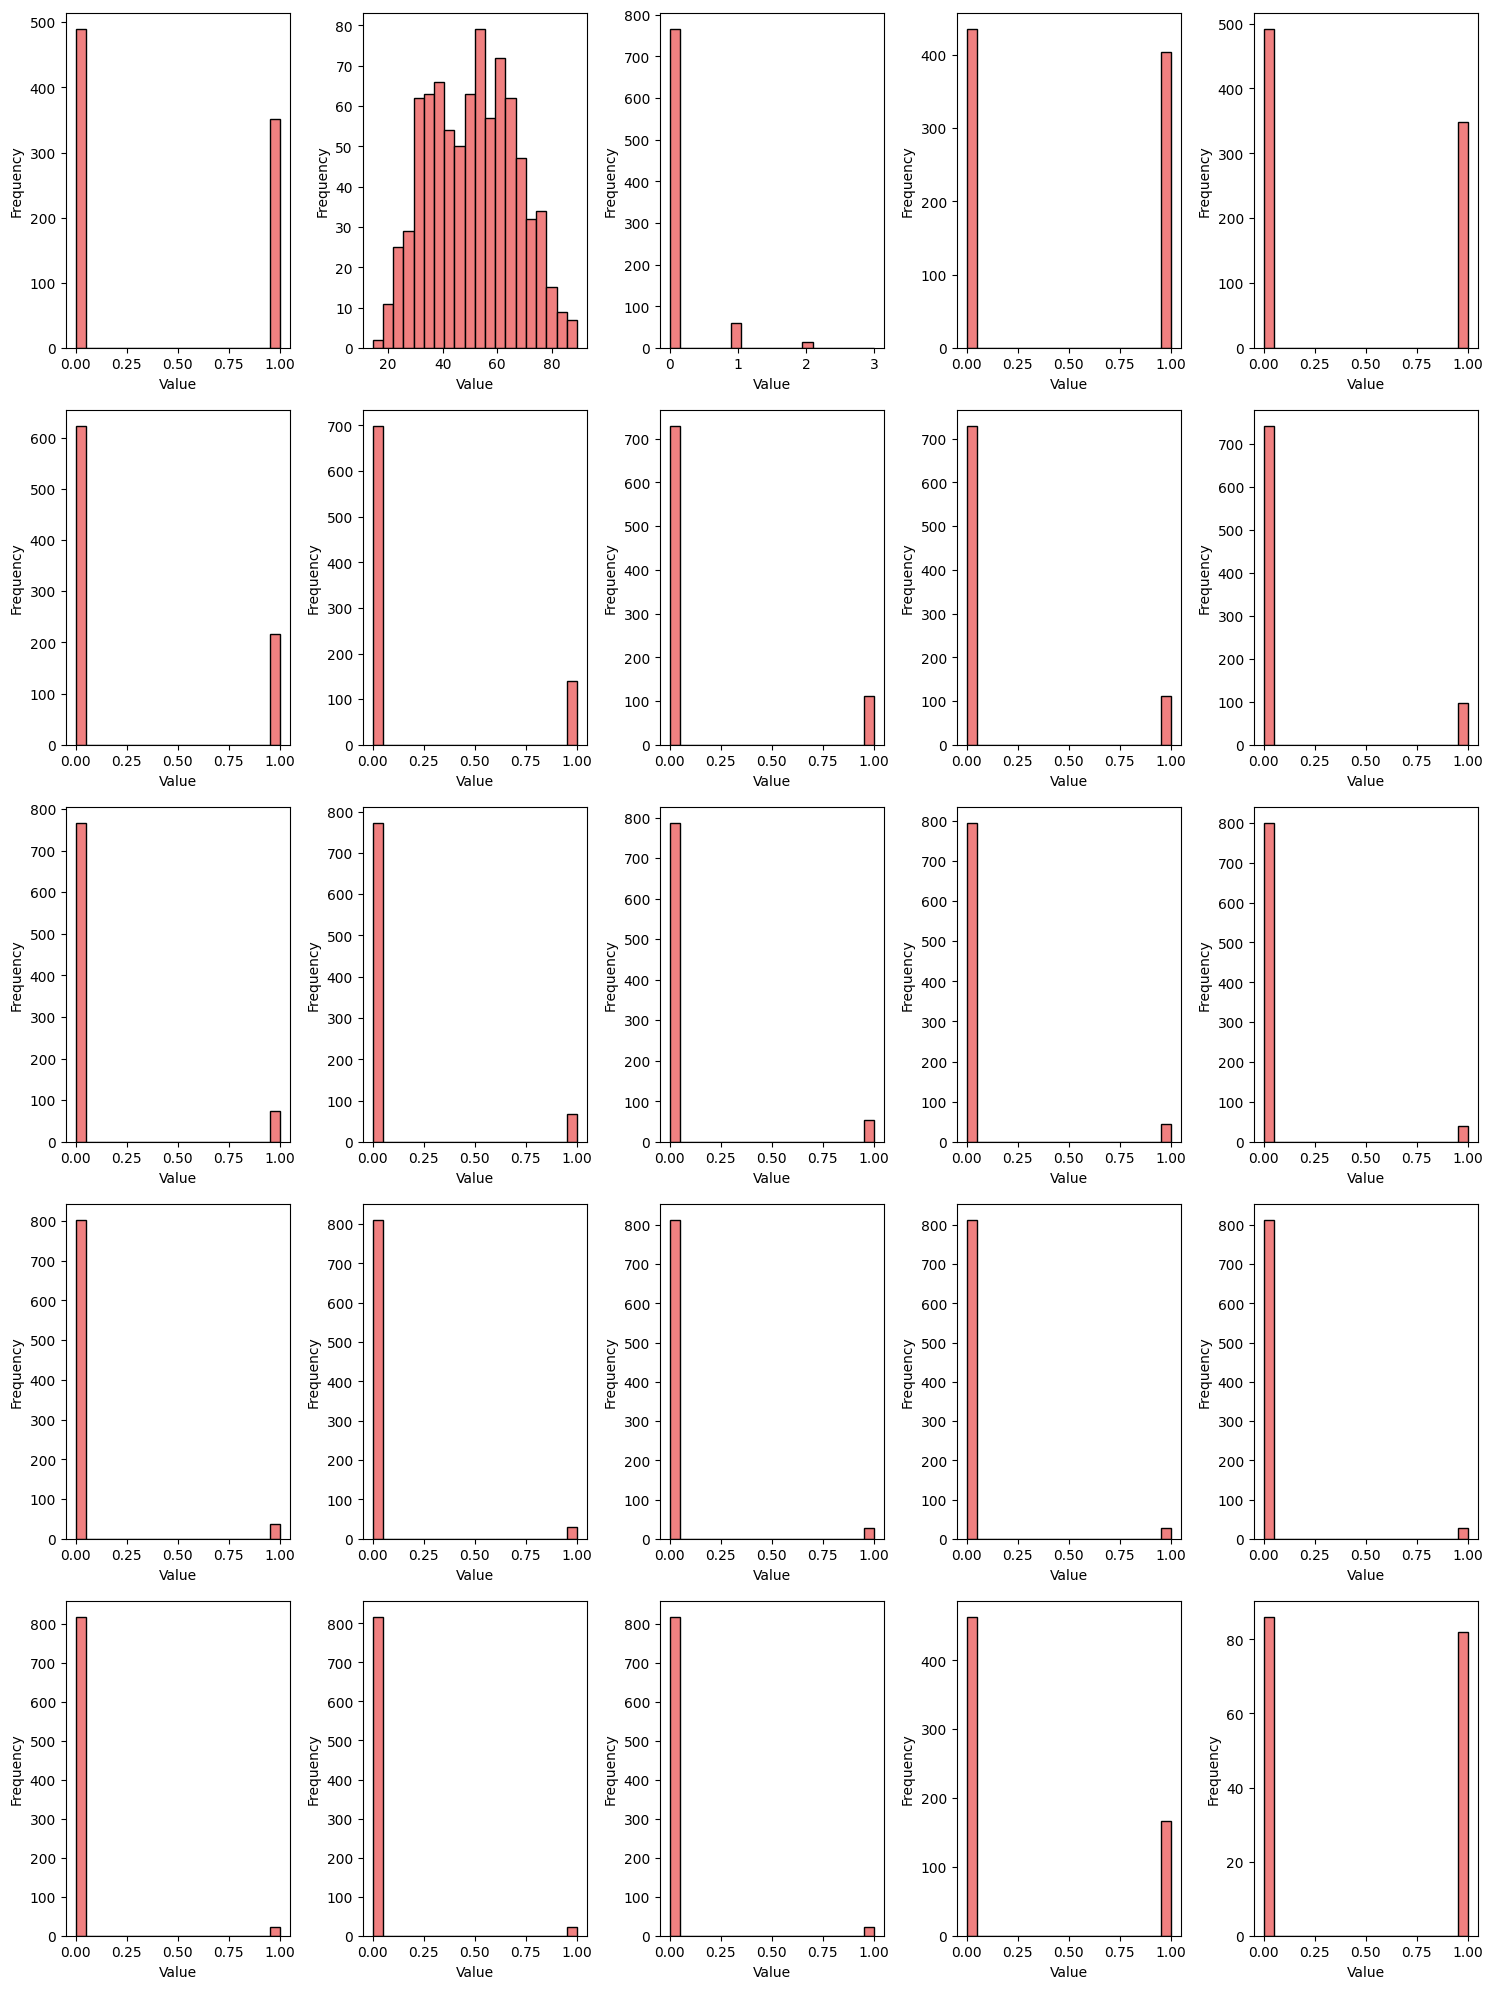

In [13]:
# Plot the distribution of data in all columns
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15,20))
axs = axs.flatten()

# now to plot for every column we apply for loop
for i, column in enumerate(gliomas.drop(columns=["Grade"]).columns):
    axs[i].hist(gliomas[column], bins=20, color='lightcoral', edgecolor='black')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Identify and Handle Missing Values

* Note that np.nan values are inserted into the original dataset specifically to demonstrate techniques that help handel these datasets

In [15]:
# Calculate the % of missing values in each column
gliomas.isna().sum()/len(gliomas)*100

Grade                0.119048
Gender               0.000000
Age_at_diagnosis     0.119048
Race                 0.119048
IDH1                 0.119048
TP53                 0.119048
ATRX                 0.119048
PTEN                 0.119048
EGFR                 0.000000
CIC                  0.119048
MUC16                0.119048
PIK3CA               0.119048
NF1                  0.119048
PIK3R1               0.000000
FUBP1                0.119048
RB1                  0.119048
NOTCH1               0.000000
BCOR                 0.119048
CSMD3                0.119048
SMARCA4              0.119048
GRIN2A               0.119048
IDH2                 0.000000
FAT4                 0.119048
PDGFRA               0.000000
ATRX_xNA            25.000000
IDH1_xNA            80.000000
dtype: float64

In [16]:
# Remove rows with missing values in the 'Grade' column
gliomas.dropna(subset=["Grade"], axis=0, inplace=True)

In [17]:
# % of missing values in each column
gliomas.isna().sum()/len(gliomas)*100

Grade                0.000000
Gender               0.000000
Age_at_diagnosis     0.000000
Race                 0.000000
IDH1                 0.000000
TP53                 0.000000
ATRX                 0.000000
PTEN                 0.000000
EGFR                 0.000000
CIC                  0.000000
MUC16                0.000000
PIK3CA               0.000000
NF1                  0.000000
PIK3R1               0.000000
FUBP1                0.000000
RB1                  0.000000
NOTCH1               0.000000
BCOR                 0.000000
CSMD3                0.000000
SMARCA4              0.000000
GRIN2A               0.000000
IDH2                 0.000000
FAT4                 0.000000
PDGFRA               0.000000
ATRX_xNA            24.910608
IDH1_xNA            79.976162
dtype: float64

#### Keep columns with at least 95% non-missing values

In [18]:
threshold = int(0.95 * len(gliomas))
# Keep columns with at least 95% non-missing values
gliomas.dropna(thresh=threshold, axis=1, inplace=True)
gliomas.isna().sum()/len(gliomas)*100

Grade               0.0
Gender              0.0
Age_at_diagnosis    0.0
Race                0.0
IDH1                0.0
TP53                0.0
ATRX                0.0
PTEN                0.0
EGFR                0.0
CIC                 0.0
MUC16               0.0
PIK3CA              0.0
NF1                 0.0
PIK3R1              0.0
FUBP1               0.0
RB1                 0.0
NOTCH1              0.0
BCOR                0.0
CSMD3               0.0
SMARCA4             0.0
GRIN2A              0.0
IDH2                0.0
FAT4                0.0
PDGFRA              0.0
dtype: float64

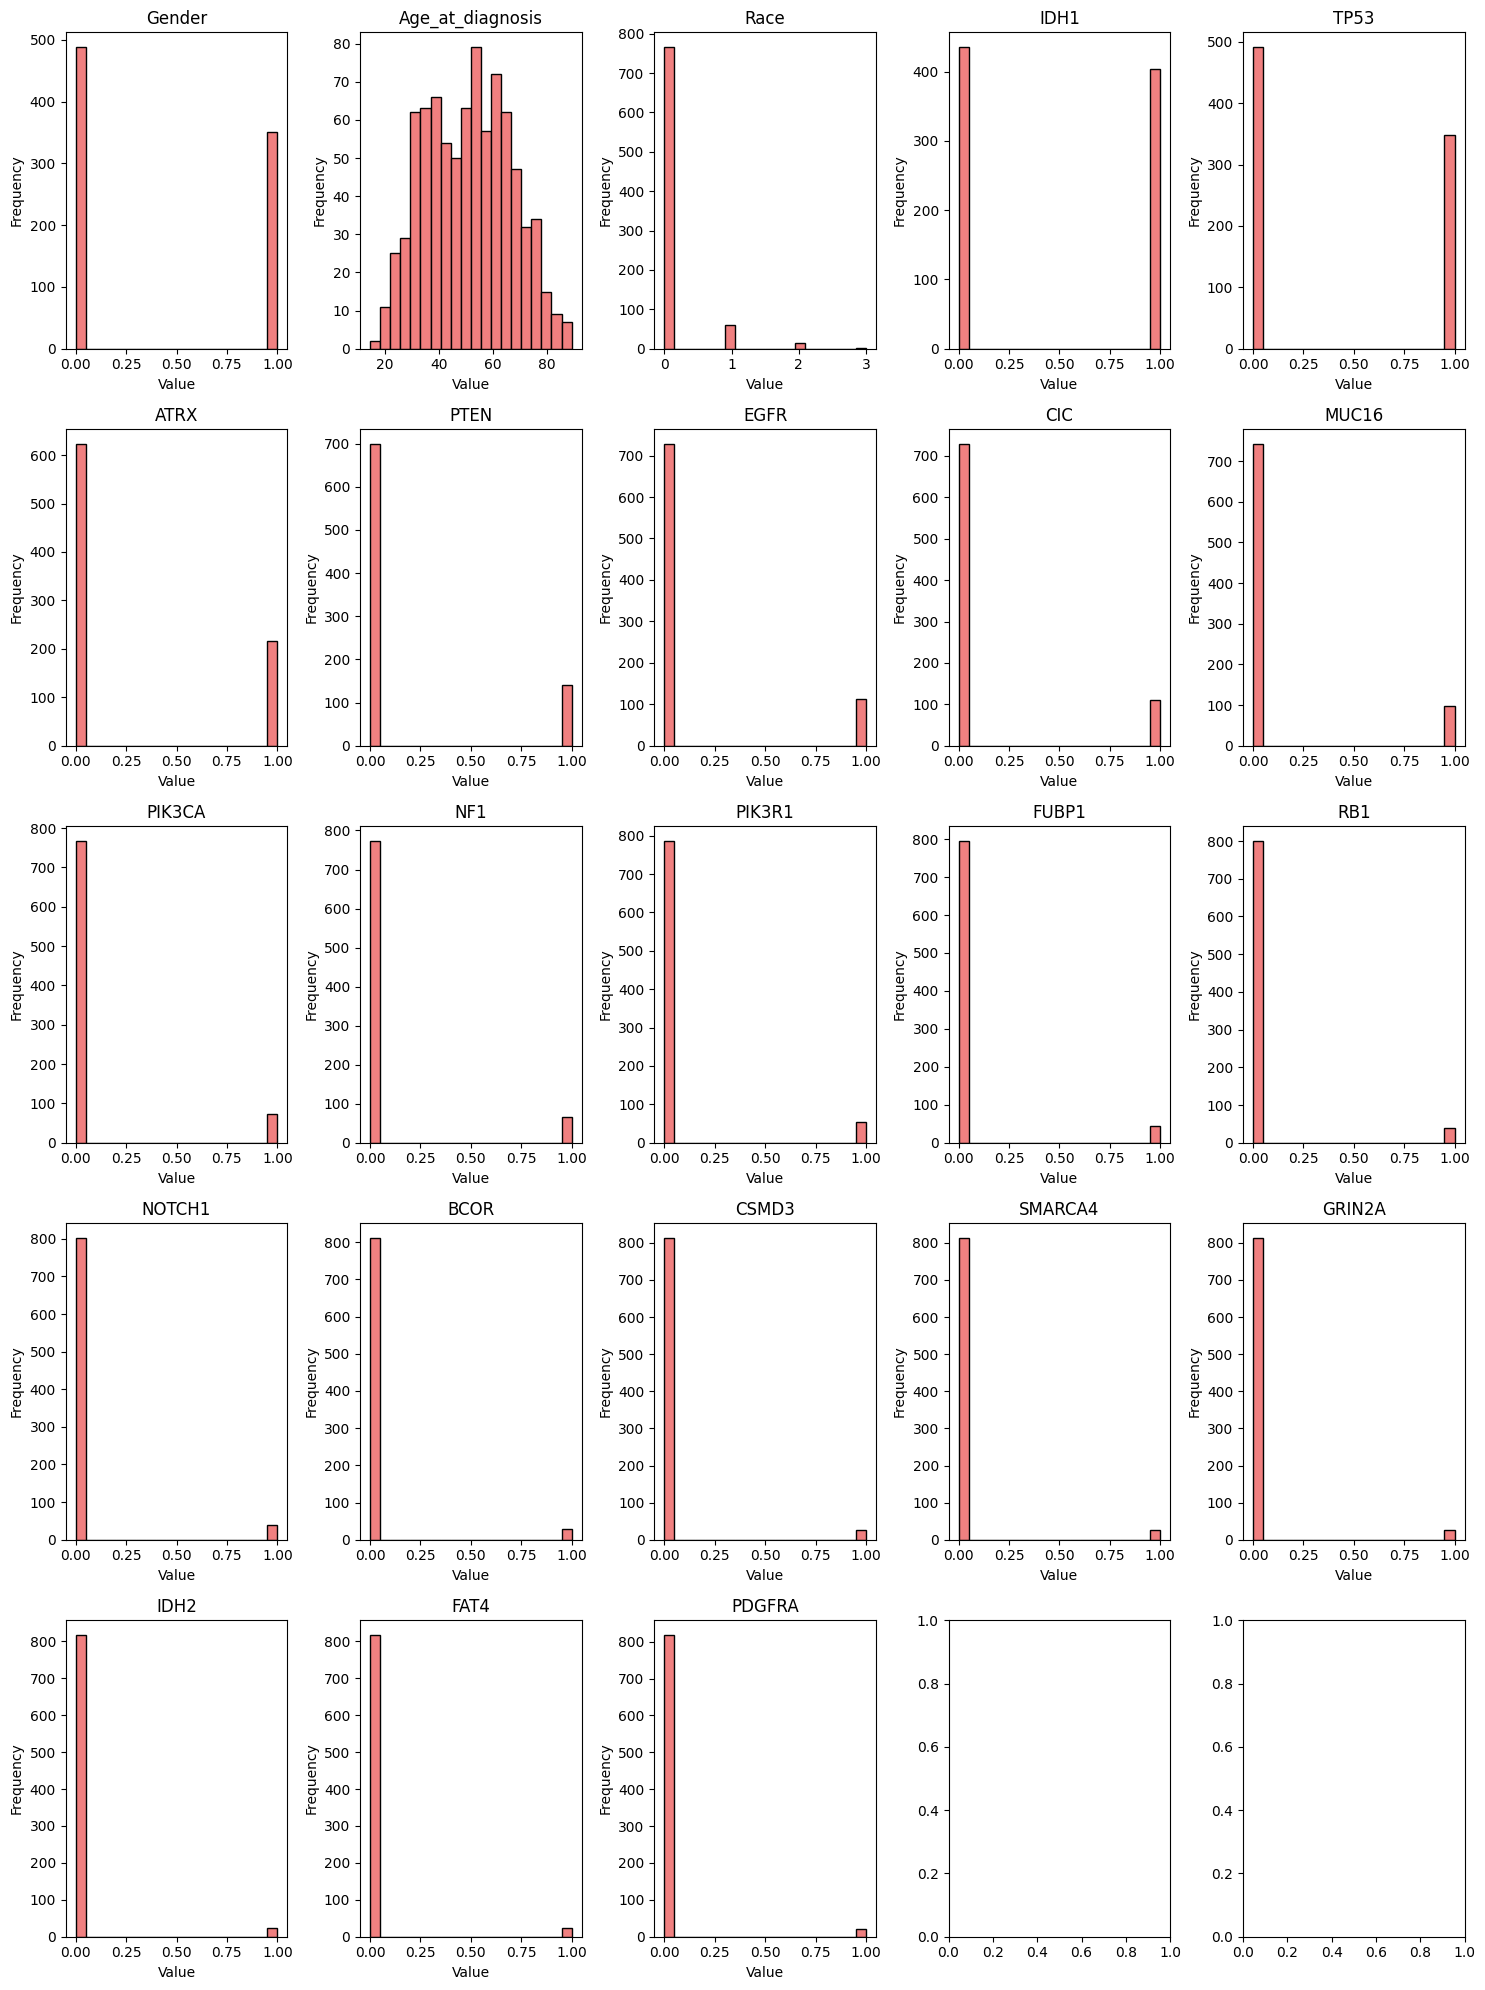

In [19]:
# Plot the distribution of data in all columns
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 20))
axs = axs.flatten()

# Iterate over each column and plot the distribution
for i, column in enumerate(gliomas.drop(columns=["Grade"]).columns):
    axs[i].hist(gliomas[column], bins=20, color='lightcoral', edgecolor='black')
    axs[i].set_title(column)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
# Drop the 'Race' column
gliomas.drop(columns=["Race"], inplace=True)

When a category within a feature has very few samples (e.g., "Race"), a model might learn patterns from these specific few instances that are not generalizable to the wider population or new data. It essentially "memorizes" these rare cases and their associated outcomes, which can lead to poor performance on unseen data.

## Split original dataset
So here, we are splitting our data into training and test sets, nothing new. But the `Grade` column is our target variable, and it's binary (0 = LGG, 1 = GBM). If we just randomly split the dataset without thinking, we could accidentally end up with more of one class in either training or testing. That would  mess up with the model evaluation, especially if one class dominates the othr.

By using `stratify=gliomas["Grade"]`, we’re making sure that the proportion of class 0 and class 1 is the same in both training and test sets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    gliomas.drop("Grade", axis=1),
    gliomas["Grade"],
    test_size=0.3,
    random_state=42,
    stratify=gliomas["Grade"],
)
print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (587, 22) X_test: (252, 22) y_train: (587,) y_test: (252,)


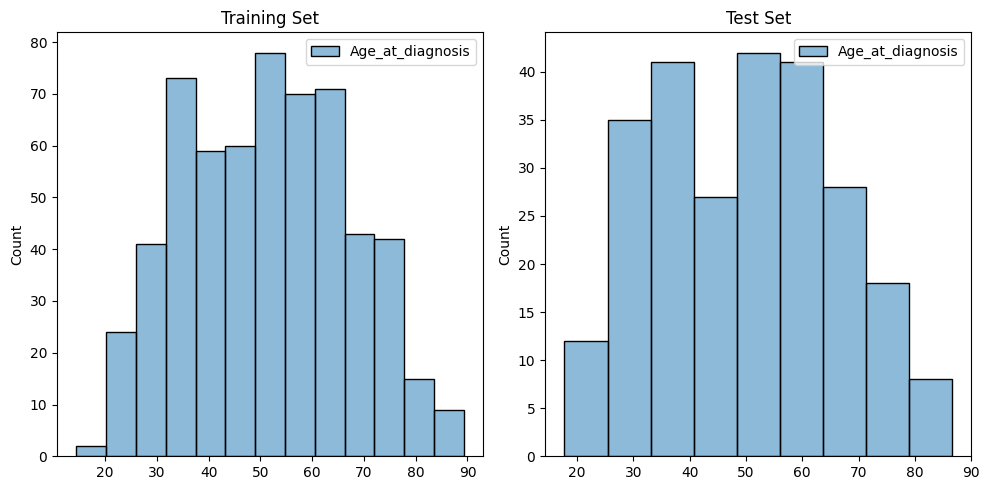

In [22]:
# Visulize the distribution of the target variable in the training and training set

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(X_train[['Age_at_diagnosis']], ax=axes[0])
axes[0].set_title('Training Set')

sns.histplot(X_test[['Age_at_diagnosis']], ax=axes[1])
axes[1].set_title('Test Set')

plt.tight_layout()
plt.show()


In [23]:
# Fit and transform the 'age' column
## Apply simple transformation using the StandardScaler `scaler = StandardScaler()`
## directly on the 'Age_at_diagnosis' column in train and test datasets
scaler = StandardScaler()
X_train['Age_at_diagnosis'] = scaler.fit_transform(X_train[['Age_at_diagnosis']])
X_test['Age_at_diagnosis'] = scaler.transform(X_test[['Age_at_diagnosis']])


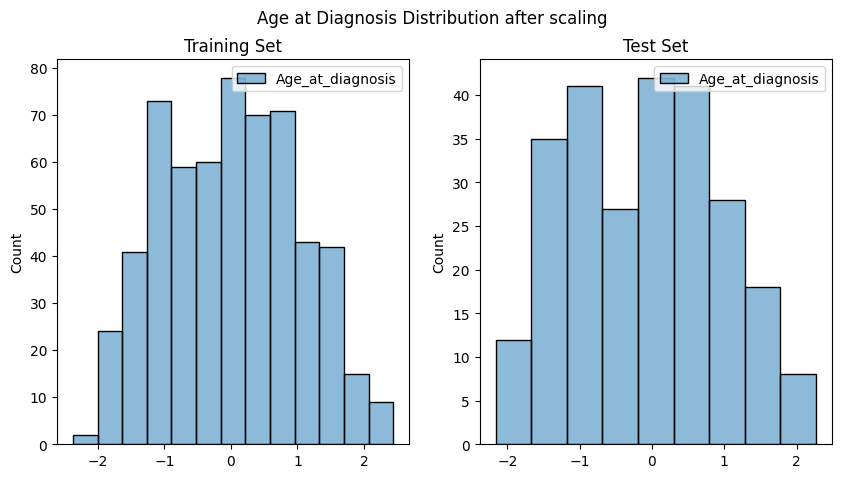

In [24]:
# Visulize the distribution of the target variable in the training and training set

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(X_train[['Age_at_diagnosis']], ax=axes[0])
axes[0].set_title('Training Set')

sns.histplot(X_test[['Age_at_diagnosis']], ax=axes[1])
axes[1].set_title('Test Set')

plt.suptitle('Age at Diagnosis Distribution after scaling')
plt.show()


## Logistic regression model

In [25]:
lr = LogisticRegression()

# Fit the model
lr.fit(X_train, y_train)


LogisticRegression()

In [26]:
# Predict the Glioma type of the new dataset
lr.predict(X_test)


array([1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1.

In [27]:
# Examine and understand the importance of features in predicting glioma type
feature_list = gliomas.columns[1:]
print("Number of Features", len(feature_list))
print("Features", feature_list)


Number of Features 22
Features Index(['Gender', 'Age_at_diagnosis', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR',
       'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1',
       'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA'],
      dtype='object')


In [28]:
# Create a DataFrame of the coefficients an their corresponding features
coefficients = pd.DataFrame(lr.coef_.T, index=feature_list, columns=['Coefficient'])
coefficients.sort_values(by='Coefficient', ascending=False)


,Coefficient
GRIN2A,1.056014
PIK3R1,0.946648
TP53,0.942277
PTEN,0.797627
Age_at_diagnosis,0.673566
MUC16,0.604058
PDGFRA,0.445156
BCOR,0.354251
CSMD3,0.273943
RB1,0.156225


## Evaluate Model Performance

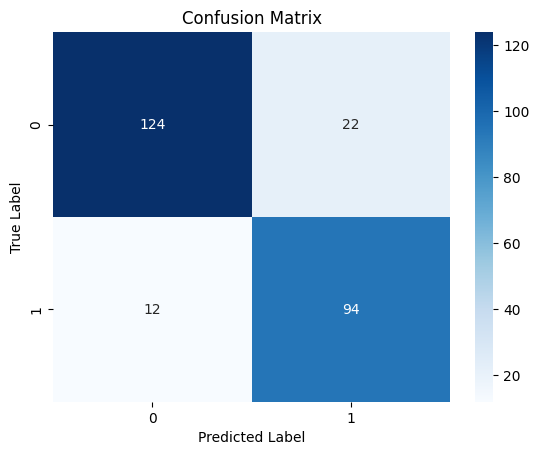

In [29]:
# Predict on test set
y_pred = lr.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [30]:
# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       146
         1.0       0.81      0.89      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.87      0.87       252



### The problems with single test dataset (holdout sets) in model validation

* Using different random seeds can lead to different results even when using the same model and dataset
* The variability in results makes it difficult to accurately assess the model’s true performance and generalizability
* Cross-validation is proposed as the gold-standard solution to overcome the limitations of holdout sets in model validation

## Cross-validation

* Cross-validation is a method that involves running a single model on various training/validation combinations to get more confident final metrics

In [31]:
# Use KFold and create kf object
kf = KFold(n_splits=5, shuffle=True, random_state=1111)

# Create splits
## The `split` method of the KFold object will yield indices for training and validation sets
splits = kf.split(gliomas.drop("Grade", axis=1))

# Print the indices of the training and validation sets for each fold
for split, k in zip(splits, range(1, 6)):
    print("Fold %d" % k)
    train_index, val_index = split
    print("Number of training indices: %s; First 10: %s" % (len(train_index), train_index[:10]))
    print("Number of validation indices: %s; First 10: %s" % (len(val_index), val_index[:10]))


Fold 1
Number of training indices: 671; First 10: [ 2  3  5  6  8  9 10 11 12 13]
Number of validation indices: 168; First 10: [ 0  1  4  7 23 25 32 33 34 38]
Fold 2
Number of training indices: 671; First 10: [ 0  1  3  4  5  6  7  8  9 10]
Number of validation indices: 168; First 10: [ 2 12 16 24 35 39 45 49 57 61]
Fold 3
Number of training indices: 671; First 10: [ 0  1  2  3  4  6  7  8  9 10]
Number of validation indices: 168; First 10: [ 5 13 26 27 29 36 37 41 46 47]
Fold 4
Number of training indices: 671; First 10: [ 0  1  2  4  5  7  9 12 13 14]
Number of validation indices: 168; First 10: [ 3  6  8 10 11 19 22 31 40 43]
Fold 5
Number of training indices: 672; First 10: [ 0  1  2  3  4  5  6  7  8 10]
Number of validation indices: 167; First 10: [ 9 14 15 17 18 20 21 28 30 42]


In [32]:
X = gliomas.drop("Grade", axis=1)
y = gliomas["Grade"]


kf = KFold(n_splits=5, shuffle=True, random_state=1111)
splits = kf.split(gliomas.drop("Grade", axis=1))

kf_cv_scores = {
    "Fold": [],
    "Precision_Class_0": [],
    "Precision_Class_1": [],
    "Recall_Class_0": [],
    "Recall_Class_1": [],
    "F1_Class_0": [],
    "F1_Class_1": [],
}

# Initialize scaler
scaler = StandardScaler()
fold = 1

for train_index, val_index in splits:
    # Setup the training and validation data
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]

    # Create copies to avoid modifying original data
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    
    # Scale only the Age_at_diagnosis column
    X_train_scaled['Age_at_diagnosis'] = scaler.fit_transform(X_train[['Age_at_diagnosis']]).flatten()
    X_val_scaled['Age_at_diagnosis'] = scaler.transform(X_val[['Age_at_diagnosis']]).flatten()
    
    # Initialize the Logistic Regression model with cross-validation
    lr_cv = LogisticRegression()

    # Use the SCALED data for training and prediction
    lr_cv.fit(X_train_scaled, y_train)  # ← Now using scaled data
    predictions = lr_cv.predict(X_val_scaled)  # ← Now using scaled data

    precision = precision_score(y_val, predictions, average=None)
    recall = recall_score(y_val, predictions, average=None)
    f1 = f1_score(y_val, predictions, average=None)

    kf_cv_scores["Fold"].append(fold)
    kf_cv_scores["Precision_Class_0"].append(round(float(precision[0]),3))
    kf_cv_scores["Recall_Class_0"].append(round(float(recall[0]),3))
    kf_cv_scores["Precision_Class_1"].append(round(float(precision[1]),3))
    kf_cv_scores["Recall_Class_1"].append(round(float(recall[1]),3))
    kf_cv_scores["F1_Class_0"].append(round(float(f1[0]),3))
    kf_cv_scores["F1_Class_1"].append(round(float(f1[1]),3))
    fold += 1

kf_cv_scores

{'Fold': [1, 2, 3, 4, 5],
 'Precision_Class_0': [0.933, 0.948, 0.937, 0.862, 0.966],
 'Precision_Class_1': [0.782, 0.78, 0.795, 0.824, 0.863],
 'Recall_Class_0': [0.832, 0.785, 0.856, 0.862, 0.884],
 'Recall_Class_1': [0.91, 0.947, 0.906, 0.824, 0.958],
 'F1_Class_0': [0.88, 0.859, 0.894, 0.862, 0.923],
 'F1_Class_1': [0.841, 0.855, 0.847, 0.824, 0.908]}

In [33]:
kf_cv_scores_df = pd.DataFrame(kf_cv_scores)
kf_cv_scores_df

,Fold,Precision_Class_0,Precision_Class_1,Recall_Class_0,Recall_Class_1,F1_Class_0,F1_Class_1
0,1,0.933,0.782,0.832,0.910,0.880,0.841
1,2,0.948,0.780,0.785,0.947,0.859,0.855
2,3,0.937,0.795,0.856,0.906,0.894,0.847
3,4,0.862,0.824,0.862,0.824,0.862,0.824
4,5,0.966,0.863,0.884,0.958,0.923,0.908


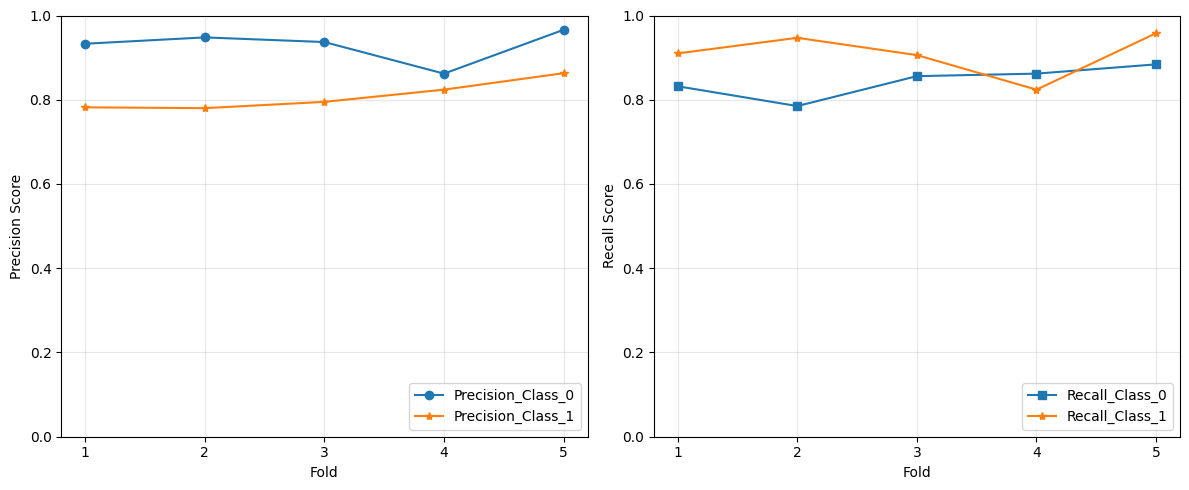

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Line plot showing variation across folds
ax1.plot(kf_cv_scores['Fold'], kf_cv_scores['Precision_Class_0'], '-o', label='Precision_Class_0')
ax1.plot(kf_cv_scores['Fold'], kf_cv_scores['Precision_Class_1'], '-*', label='Precision_Class_1')

ax1.set_xlabel('Fold')
ax1.set_xticks(kf_cv_scores['Fold'])
ax1.set_ylabel('Precision Score')
ax1.set_ylim(0, 1)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

ax2.plot(kf_cv_scores['Fold'], kf_cv_scores['Recall_Class_0'], '-s', label='Recall_Class_0')
ax2.plot(kf_cv_scores['Fold'], kf_cv_scores['Recall_Class_1'], '-*', label='Recall_Class_1')

ax2.set_xlabel('Fold')
ax2.set_xticks(kf_cv_scores['Fold'])
ax2.set_ylabel('Recall Score')
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [35]:
cv_summary = kf_cv_scores_df.aggregate(
    {
        "Precision_Class_0": ["min", "max", "mean", "std"],
        "Precision_Class_1": ["min", "max", "mean", "std"],
        "Recall_Class_0": ["min", "max", "mean", "std"],
        "Recall_Class_1": ["min", "max", "mean", "std"],
        "F1_Class_0": ["min", "max", "mean", "std"],
        "F1_Class_1": ["min", "max", "mean", "std"],
    }
)
cv_summary


,Precision_Class_0,Precision_Class_1,Recall_Class_0,Recall_Class_1,F1_Class_0,F1_Class_1
min,0.862000,0.780000,0.785000,0.824000,0.859000,0.824000
max,0.966000,0.863000,0.884000,0.958000,0.923000,0.908000
mean,0.929200,0.808800,0.843800,0.909000,0.883600,0.855000
std,0.039682,0.035024,0.037725,0.052631,0.026197,0.031741


**Interpretation guidelines:**

1. Mean Performance:
   * Higher mean = better overall performance
   * Compare to baseline or business requirements

2. Standard Deviation:
   * Low SD = consistent performance across folds (good generalization)
   * High SD = variable performance (potential overfitting or data issues)

3. Range and Min/Max:
   * Small range = consistent across different data subsets
   * Large range = sensitive to specific data characteristics


## Hyperparameter Tuning

### Hyperparameters:

* Set before training begins
* Configure model architecture/behavior
* Not learned; require manual tuning
* Core hyperparameters in `LogisticRegression`:
  * Penalty (loss): 'l1', 'l2', 'elasticnet', None (Default: 'l2')
  * Regularization strength: smaller values mean stronger regularization (Default: 1.0)
  * Solver (Algorithm to use for optimization): `newton-cg`, `lbfgs`, `liblinear`, `sag`, `saga` (Default: `lbfgs`)
* Core Hyperparameters can
  * Directly influence model’s learning process and capabilities
  * Control model complexity, learning behavior, and prevention of overfitting
  * Changes significantly impact accuracy, generalization, and prediction quality

Additional notes (regarding parameters used in following cell):

* `C` (Regularization Strength):
  * Controls how much to penalize complex models
  * Smaller values = more regularization (simpler model)
* Loss function (penalty):
  * `l2`: Ridge regularization (shrinks coefficients toward zero)
  * `l1`: Lasso regularization (can set coefficients exactly to zero, good for feature selection)
* solver:
  * `liblinear`: Good for small datasets, works with both L1 and L2
  * `saga`: Good for large datasets, works with both L1 and L2
  * `ElasticNet`: Combines `L1` and `L2` benefits (address multicollinearity handle groups of correlated genes)
  * 
* `max_iter:`
  * Maximum number of iterations for the algorithm to converge
  * Increase if you get convergence warnings




In [37]:
# Get the features and target variable
X_train, X_test, y_train, y_test = train_test_split(
    gliomas.drop("Grade", axis=1),
    gliomas["Grade"],
    test_size=0.3,
    random_state=42,
    stratify=gliomas["Grade"],
)

# Create the base model
lr = LogisticRegression(random_state=42, max_iter=10000)

# Define the parameter grid
# Define a VALID parameter grid
param_grid = [
    # For l2 penalty (works with all solvers)
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
    },
    # For l1 penalty (only works with liblinear and saga)
    {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    },
    # For elasticnet penalty (only works with saga)
    # Note: l1_ratio must be between 0 and 1
    {
        'penalty': ['elasticnet'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'solver': ['saga'],
        'C': [0.1, 1, 10]

    }
]

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_macro',  # Assessment metric
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Access results for different metrics
print(f"Best parameters (based on f1):", grid_search.best_params_)
print(f"Best f1 score:", grid_search.best_score_)

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\nTest set accuracy:", best_model.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 51 candidates, totalling 255 fits
Best parameters (based on f1): {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best f1 score: 0.8708974463864253

Test set accuracy: 0.8690476190476191

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       146
         1.0       0.81      0.90      0.85       106

    accuracy                           0.87       252
   macro avg       0.87      0.87      0.87       252
weighted avg       0.87      0.87      0.87       252



### Random Forest Classifier with Grid Search and 5-Fold Cross Validation

Now we’re setting up a Random Forest model and tuning its hyperparameters using grid search. We give a range of setting for these parameters and finding out the best possible combination among these using GridSearch.

So first, we define a set of parameters that we want to experiment with. Like how many trees to grow, how deep the trees can go, and how strict the splitting rule should be. We also try both class weighting options — one where all classes are treated equally, and one where the model gives more importance to the minority class (which can help if there’s class imbalance).

Then, we do GridSearchCV. What this does is take every possible combination of those parameters and evaluate them using **5-fold cross-validation**. That means it splits the training data into 5 chunks, trains on 4, validates on 1, and repeats this process five times. It does this for every parameter combo, so in the end, we get a pretty reliable estimate of which settings give us the best performance

We're using **macro F1 score** as the evaluation metric, which averages F1 scores for both classes equally. That iss helpful when both classes matter, not just the dominant one

Once it finds the best model, we use it to predict on the test set and evaluate its final performance


In [40]:
# setting up the hyperparameters of the random forest classifier
rf_param_grid = {
    'n_estimators': [100, 200],       # Try with 100 trees and 200 trees
    'max_depth': [None, 10, 20],      # No limit vs limit trees to depth 10 or 20
    'min_samples_split': [2, 5],      # Minimum number of samples required to split a node
    'class_weight': [None, 'balanced']  # Try normal vs. adjust for class imbalance
}

# setting up the out of the box random forest model
rf = RandomForestClassifier(random_state=42)

# now actual grid search to tune our hyperparameters with 5-fold cross validation
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,                            # 5-fold CV (split data 5 ways, train/test each fold)
    scoring='f1_macro',              # Use macro-averaged F1 as the evaluation metric
    verbose=1,                       # Print progress during fitting
    n_jobs=-1                        # Use all CPU cores for parallel processing
)

# fitting the model after grid search
rf_grid.fit(X_train, y_train)

# Access results for different metrics
print("Best parameters:", rf_grid.best_params_)
print("Best F1 score:", rf_grid.best_score_)

# Make predictions with the best model
best_rf = rf_grid.best_estimator_
rf_preds = best_rf.predict(X_test)

# Evaluate the best model
print("\nTest set accuracy:", best_rf.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, rf_preds))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 score: 0.8760874240695852

Test set accuracy: 0.8650793650793651

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       146
         1.0       0.81      0.90      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.87      0.87       252



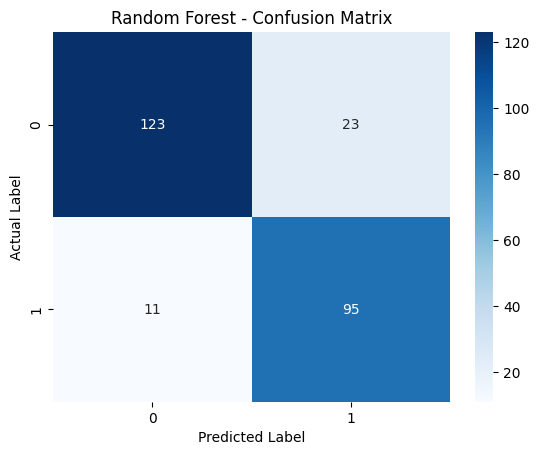

In [42]:
# This creates a confusion matrix — helps me see where the model got confused
cm = confusion_matrix(y_test, rf_preds)

# Plotting the matrix so it’s easier to understand
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

### LinearSVC with Grid Search and 5-Fold Cross Validation

Now we are building a LinearSVC model and using grid search to find the best combination of hyperparameters. Like before, we define a range of values for each setting we want to tune and let GridSearchCV try them out to see what works best

For LinearSVC, the parameters we are tuning include the regularization strength `C`, the penalty type (`l1` or `l2`), and the `dual` setting which is needed for certain combinations of data size and penalty. The regularization strength basically controls how much we want to penalize complex models, which helps with generalization. The penalty type changes how the model handles regularization, `l1` can zero out less important features, while `l2` shrinks all weights but doesn’t eliminate them

Then we run GridSearchCV, which tries every combination of these settings and evaluates them using 5-fold cross validation. It splits the training data into five parts, trains on four of them, validates on the fifth, and does this five times so that every part gets used as a validation set once. That way, we are not depending on a single random split to judge performance

We are again using macro F1 score as the evaluation metric, which makes sure both classes are treated equally during evaluation

Once the best combination is found, we use that model to make predictions on the test set and evaluate how it performs


In [44]:
# import additionl libraries for Linear SVC
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [45]:
# now we need to only scale the age_at_diagnosis coulmn
# Step 1: Identify the column names
numeric_features = ['Age_at_diagnosis']  # Only this gets scaled
binary_features = [col for col in X_train.columns if col not in numeric_features]

# Step 2: Column transformer to scale only Age_at_diagnosis
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Scale only this
        ('bin', 'passthrough', binary_features)       # Leave others unchanged
    ]
)

# Step 3: Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),                   # First: scale age only
    ('svc', LinearSVC(max_iter=10000))                # Then: train linear SVM
])

# Step 4: Define parameter grid for GridSearchCV
param_grid = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__penalty': ['l1', 'l2'],
    'svc__dual': [False]  # Required when using L1 penalty
}

In [48]:
svc_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

svc_grid.fit(X_train, y_train)
best_svc = svc_grid.best_estimator_


svc_preds = best_svc.predict(X_test)

# Access results for different metrics
print("Best F1 score:", svc_grid.best_score_)

print("Best Parameters:", svc_grid.best_params_)
print("\nTest Accuracy:", best_svc.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, svc_preds))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best F1 score: 0.8741426074192903
Best Parameters: {'svc__C': 10, 'svc__dual': False, 'svc__penalty': 'l2'}

Test Accuracy: 0.8650793650793651

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       146
         1.0       0.81      0.90      0.85       106

    accuracy                           0.87       252
   macro avg       0.86      0.87      0.86       252
weighted avg       0.87      0.87      0.87       252



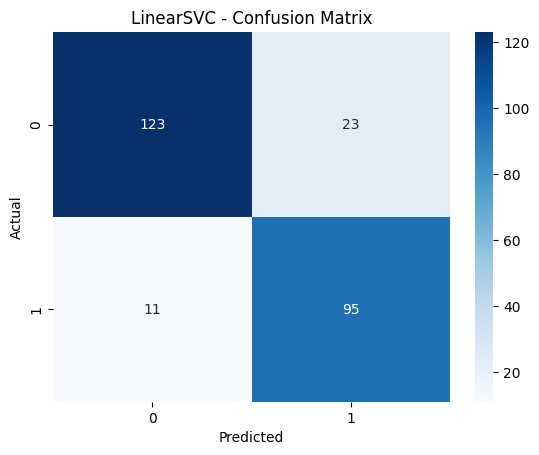

In [49]:
cm = confusion_matrix(y_test, svc_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LinearSVC - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### k-Nearest Neighbors with Grid Search and 5-Fold Cross Validation

Here we are setting up a k-Nearest Neighbors classifier and tuning its hyperparameters using grid search. Just like the other models, we define a range of settings and let GridSearchCV figure out which combination gives the best results

For k-NN, the most important thing to tune is `k`, which is the number of neighbors to consider when making a prediction. We also test different weighting strategies, either giving equal weight to all neighbors, or giving more influence to closer ones. Finally, we try out different distance metrics like Euclidean or Minkowski to see which works better for our data

We use GridSearchCV with 5-fold cross validation to evaluate each combination of parameters. This means the training data is split into five parts, the model is trained on four and validated on the fifth, and this process is repeated five times. This helps reduce the chances of overfitting to one specific train-test split

Since k-NN is a distance-based algorithm, it is very sensitive to feature scale. That’s why we scale only the `Age_at_diagnosis` feature while leaving the 0 and 1 gene mutation values unchanged

We are again using macro F1 score as our evaluation metric to make sure both classes are treated equally

After finding the best performing combination, we use the final model to make predictions on the test set and evaluate how well it performs


In [51]:
# This pipeline does two things:
# 1. Preprocess the features (scale only age)
# 2. Train a KNeighborsClassifier model
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Only scale 'Age_at_diagnosis'
        ('bin', 'passthrough', binary_features)       # Leave binary features unchanged
    ]
)

knn_pipeline = Pipeline([
    ('preprocessor', knn_preprocessor),
    ('knn', KNeighborsClassifier())  # The actual k-NN classifier
])

In [67]:
# Now I define what combinations of kNN settings I want to test using GridSearchCV
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],         # Try different values of k
    'knn__weights': ['uniform', 'distance'], # Uniform = equal vote, Distance = closer neighbors matter more
    'knn__metric': ['minkowski', 'euclidean'] # Different distance formulas
}

In [54]:
# This will try all combinations of parameters in knn_param_grid
# It will use 5-fold cross-validation on the training set
knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=5,                        # 5-fold CV
    scoring='f1_macro',          # Use macro F1 score as metric
    verbose=1,                   # Show progress
    n_jobs=-1                    # Use all CPU cores for speed
)

# Fit the grid search to the training data
knn_grid.fit(X_train, y_train)

# Get the best performing model and make prediction with it
best_knn = knn_grid.best_estimator_
knn_preds = best_knn.predict(X_test)

# Access results for different metrics
print(f"Best parameters (based on f1):", knn_grid.best_params_)
print(f"Best f1 score:", knn_grid.best_score_)

# Evaluate test set performance
print("\nClassification Report:")
print(classification_report(y_test, knn_preds))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters (based on f1): {'knn__metric': 'minkowski', 'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Best f1 score: 0.8565244362156916

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       146
         1.0       0.81      0.85      0.83       106

    accuracy                           0.85       252
   macro avg       0.85      0.85      0.85       252
weighted avg       0.85      0.85      0.85       252



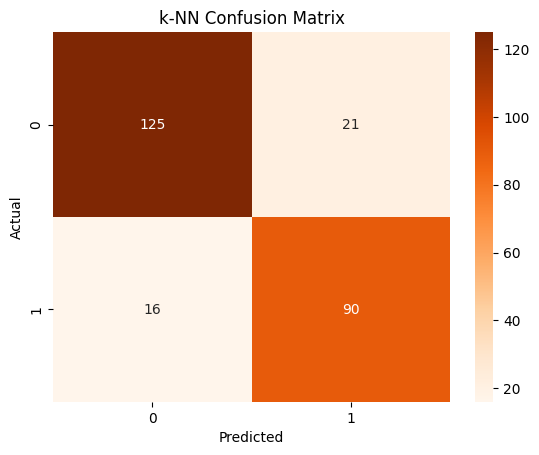

In [55]:
# Generate and visualize the confusion matrix
cm = confusion_matrix(y_test, knn_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("k-NN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Model Performance Comparison

Finally, now we compare the performances of these models.

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.869048,0.811966,0.896226,0.852018
1,Random Forest,0.865079,0.805085,0.896226,0.848214
2,Linear SVC,0.865079,0.805085,0.896226,0.848214
3,k-NN,0.853175,0.810811,0.849057,0.829493


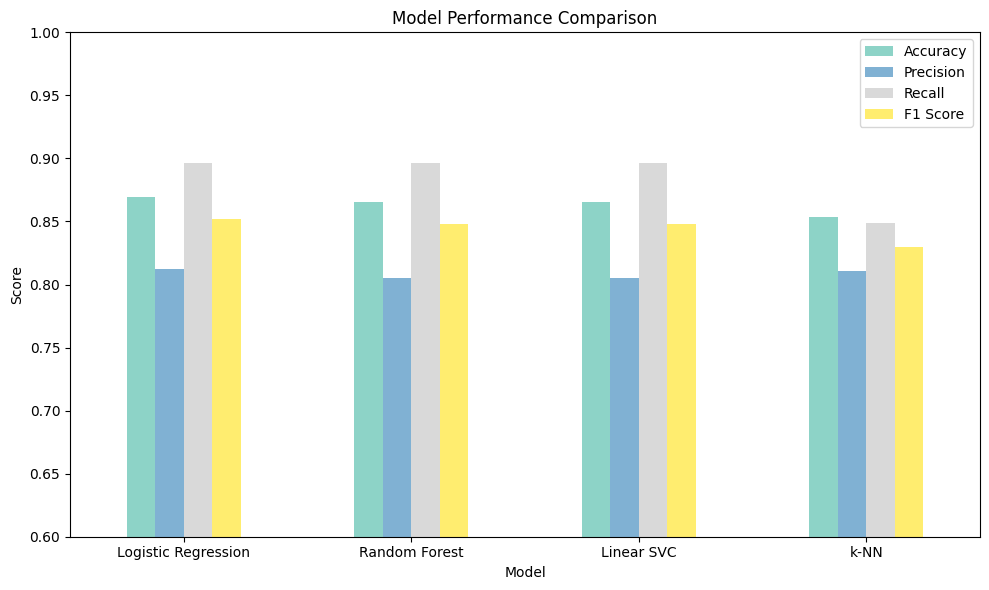

In [66]:
# List of model names
models = ['Logistic Regression', 'Random Forest', 'Linear SVC', 'k-NN']

# Accuracy scores
accuracies = [
    best_model.score(X_test, y_test),  # Logistic Regression (scaled input)
    best_rf.score(X_test, y_test),            # Random Forest
    best_svc.score(X_test, y_test),           # Linear SVC
    best_knn.score(X_test, y_test)            # k-NN
]

# Precision scores
precisions = [
    precision_score(y_test, y_pred),          # Logistic Regression
    precision_score(y_test, rf_preds),        # Random Forest
    precision_score(y_test, svc_preds),       # Linear SVC
    precision_score(y_test, knn_preds)        # k-NN
]

# Recall scores
recalls = [
    recall_score(y_test, y_pred),
    recall_score(y_test, rf_preds),
    recall_score(y_test, svc_preds),
    recall_score(y_test, knn_preds)
]

# F1 scores
f1_scores = [
    f1_score(y_test, y_pred),
    f1_score(y_test, rf_preds),
    f1_score(y_test, svc_preds),
    f1_score(y_test, knn_preds)
]

# Create a DataFrame with all metrics
summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

# Show the table
display(summary_df)

# Plot it as a bar chart
summary_df.set_index('Model').plot(
    kind='bar',
    figsize=(10, 6),
    colormap='Set3'
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.6, 1.0) 
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Now that we’ve trained and evaluated all four models, we can look at the results and see how they stack up.

Logistic Regression came out on top with the highest accuracy, precision, recall, and F1 score overall. That’s actually pretty cool, because it’s also the simplest and most interpretable model in the list. It shows that for this specific problem, a linear model with good regularization is more than enough

Random Forest and LinearSVC were right behind with slightly lower F1 scores. Both models performed well, especially in recall, which stayed consistently high across all models. That’s important because we want to catch as many GBM cases as possible

k-NN had the lowest performance out of the four, especially in recall and F1 score. Still, it wasn’t bad. It just didn’t quite match the others, possibly because it’s sensitive to feature scale and also struggles a bit when there’s overlap between classes

Overall, Logistic Regression wins in terms of performance and simplicity. Random Forest and SVC are strong backups with solid results. k-NN is okay, but not the best for this dataset

### Reflecting on Model Performance and Assumptions

Going into this, I had some assumptions about how each model might behave. I expected Random Forest to perform best because it’s non-linear and can capture interactions between features. I thought k-NN might struggle because it's sensitive to feature scaling and doesn't handle overlapping classes very well. For LinearSVC and Logistic Regression, I wasn’t sure. I figured they might underperform if the relationships between features and glioma grade were non-linear

But the results told a different story. Logistic Regression actually performed the best across all metrics: accuracy, precision, recall, and F1. That tells me the relationship between the features and the target in this dataset might  be actually fairly linear. Maybe age and a few key mutations already give enough signal, and the model didn’t need to capture complex patterns to get things right

Random Forest and LinearSVC basically tied in performance, which was interesting. Random Forest is supposed to be powerful for mixed-type data and capturing non-linearities, but it didn’t outperform Logistic Regression here. That could mean either the non-linear effects weren’t strong enough to give it an edge, or the tree-based splits weren’t very helpful on this data. LinearSVC, on the other hand, did about as well as Random Forest, and that’s with the linear kernel, so it kind of confirms the idea that this might just be a good fit for linear models

k-NN had the lowest performance, just like I expected. It’s simple, and it can work well when there are clear local clusters, but I don’t think that’s the case here. It’s also really sensitive to irrelevant features and feature scaling, and even though we scaled age, the model probably couldn’t deal with the rest of the variation across samples. 

Overall, I was genuinely surprised by how well Logistic Regression performed. It reminds us that sometimes even simpler models can outperform complex ones when the data is clean and the features are informative.
